# RACCROCHE - Module 1 & 2
This is a full workflow that shows methods regarding the construction of gene families, listing of candidate adjacencies and construction of ancestral contigs using Maximum Weight Matching.

# Section 1: Importing Libraries, Modules and Configuration File

In [1]:
# setting the Notebook Display Method
%matplotlib inline

In [2]:
# install tqdm-joblib
%pip install tqdm-joblib

# install Bio
%pip install Bio

Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libraries
import sys
import yaml
import time
import os
import io

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from Bio import Phylo
from scipy.spatial.distance import squareform

from tqdm import tqdm
import tqdm_joblib
from joblib import Parallel, delayed

# import modules
#? eventually the below list will be in your package
from GeneFamily import GeneFamily
from Genome import Genome
from MWMInputTreeNode import MWMInputTreeNode
from mwmatching import *
from Contig import *

## Parsing the Configuration File

The configuration file consists of a list of input/output directories, input files and parameters to the pipeline. 

Specifications for Input:
- leaf_genome_info: the input genomes with their positions on the phylogenetic tree, i.e. *Genomes.txt* <br>
- synteny_file_name: the post-fix of the synmap output of pairwise genome comparisons; <br>
- synteny_file_path: the path to the synmap output data <br>
- phylo_tree_path: the path to the Newick Phylogenetic Tree structure <br>
- jar_path: the path to the UniMoG jar file <br> 

__Note__: The input genomes is in the *Genomes.txt* file. 
It contains the information about input genomes, including CoGe ID, genomeName, ancestor<br>
The phylogenetic relationship is in the *phyloTree* file. 
It includes the unrooted phylogenetic tree in newick format where each tree leaf is denoted as name_CoGeID. <br>
Sample Newick Tree for the monocot project: ( ( (Spirodela_51364, Acorus_54711), Dioscorea_51051), ( (Ananas_25734, Elaeis_33018), Asparagus_33908) )

Specifications for Output:
- gene_list: path where the gene list output should be created <br>
- gene_family: path where the gene family output should be created <br>
- genomes: path where the genome string output should be created <br>
- mwm_input_template: path and template for the output files created from MWM Input step <br>
- mwm_output_template: path and template for the output files created from MWM <br>
- contig_template: path and template for the output files created from constructing contigs <br>
- dcj_output_path: path to the output file when calculating DCJ distance between ancestors <br>
- dcj_summary_path: path to the output file containing a summary of the DCJ calculations <br><br>

Global parameters:
- min_cutoff_weight: minimum similarity cutoff weight for gene family construction, i.e. *min_cutoff_weight=65*
- max_cutoff_weight: maximum similarity cutoff weight for gene family construction, i.e. *max_cutoff_weight=100*
- ws: window size, i.e. *ws=7*
- min_mwm_weight: minimum adjacency weight to be considered for maximum weight matching, i.e. *min_mwm_weight=100*
- gf1: maximum number of genes in a gene family, i.e. *gf1=50*
- gf2: the maximum number of genes from a genome in a gene family, i.e. *gf2=10*
- gf3: the minimum number of genomes in a gene family, i.e. *gf3=1*

In [3]:
# specify your Project Name

proj_name = "buxus"

# reading from the configuration file
config_file = "../inputData/project-" + proj_name + "/config.yaml"

with open(config_file, 'r') as stream:
    parsed_config = yaml.load(stream, Loader=yaml.FullLoader)
    
directory = parsed_config['output_path'] + parsed_config['project_name'] 
os.makedirs(directory, exist_ok = True)
    
print("Project Name and Input Directory:", parsed_config['input_path'] + parsed_config['project_name'])   
print("Project Name and Output Directory:", parsed_config['output_path'] + parsed_config['project_name'])  
print('''Please check required input data under the Input Directory:
\t 1. Genome.txt with info about input genomes
\t 2. phyloTree.txt with Newick Tree Structure
\t 3. SynMap results between every pair of genomes
''')
#print("Project input data directory:", parsed_config['input_file']['synteny_file_path'])    
#print("Input extant genomes info:", parsed_config['input_file']['leaf_genome_info'])
#print("The postfix of SynMap output files:", parsed_config['input_file']['synteny_file_name'])

Project Name and Input Directory: ../inputData/project-buxus
Project Name and Output Directory: ../outputData/project-buxus
Please check required input data under the Input Directory:
	 1. Genome.txt with info about input genomes
	 2. phyloTree.txt with Newick Tree Structure
	 3. SynMap results between every pair of genomes



# Section 2: Constructing Gene Families from syntenically validated orthologs from SynMap
In order to succesfully construct gene families, we require:
- Successful parsing of the configuration file <br>
- Valid parameters in the configuration file

## Reading in Input Genome Data and Tree Structure Data
Each genome is a leaf of the input phylogenetic tree. The *get_leaves_and_tree_info()* method extracts the following attribute of each genome from the input file specified by *leaf_genome_info* parameter in the configuration file.
>1) genome ID; <br>
>2) genome name; <br>
>3) most recent ancestor; <br>
>4) number of chromosomes; <br>
>5) file name of the genome annotations; <br>
>6) desired tree structure in Newick format.

In [4]:
# reading in input genome info
gene_family = GeneFamily(parsed_config)
all_leaves, median_structure, newick_structure = gene_family.get_leaves_and_tree_info()

print("Extant genomes to be analyzed in this project: \n")

genomes = pd.DataFrame(all_leaves)
display = genomes.iloc[:, :3]

display.columns = ['Genome ID', 'Genome Name', 'Ancestor']
display.set_index('Genome ID', inplace = True, drop = True)

display

Extant genomes to be analyzed in this project: 



,Genome Name,Ancestor
Genome ID,,
19990,Vitis,3
28620,Aquilegea,1
35405,Nelumbo,1
54057,Amaranthus,3
57266,Tetracentron,2
57268,Buxus,2


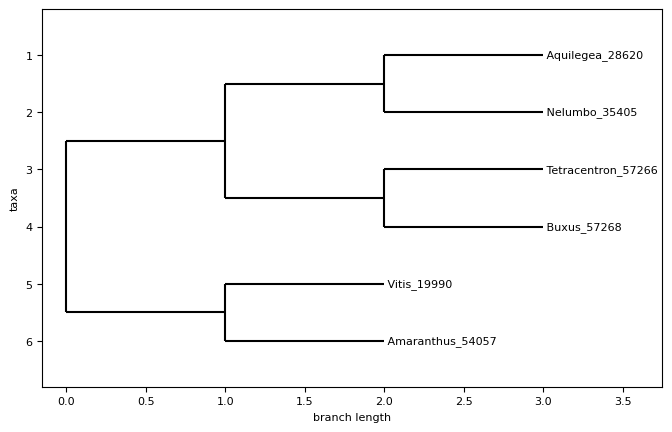

In [5]:
tree = Phylo.read(io.StringIO(newick_structure), "newick")

matplotlib.rc('font', size=8)
fig = plt.figure(figsize=(8, 5), dpi=100)
axes = fig.add_subplot(1, 1, 1)
axes.set_facecolor('white')

Phylo.draw(tree, axes = axes)

## Creating gene families from syntenically validated homology generated from SynMap

Read in all genes for every genome, record gene-related information and use gf1 (from config file), cutoff weights in order to create gene families.


In [6]:
print(all_leaves)
# creating gene families
gene_family.make_gene_family(all_leaves)

print(len(all_leaves))

[['19990', 'Vitis', '3', '19'], ['28620', 'Aquilegea', '1', '7'], ['35405', 'Nelumbo', '1', '8'], ['54057', 'Amaranthus', '3', '16'], ['57266', 'Tetracentron', '2', '19'], ['57268', 'Buxus', '2', '14']]
6


## Visualizing Gene Families
In the configuration file *config.yaml*, there are three parameters to restrict the size of gene families: 
- gf1: the maximum number of genes in a gene family
- gf2: the maximum number of genes from a single genome in a gene family
- gf3: the minimum number of genomes in a gene family <br>

In [7]:
families = list(gene_family.gene_family.keys())

values = list(gene_family.gene_family.values())
lengths = [len(values[i]) for i in range(0, len(values))]

print("Total number of gene familes:", len(families))
print("The size of the largest gene family:", max(lengths))

Total number of gene familes: 13649
The size of the largest gene family: 49


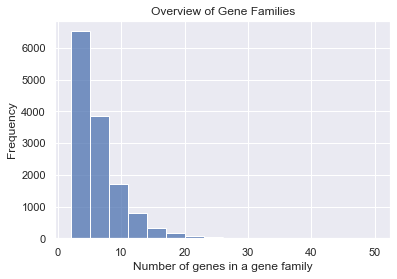

In [8]:
sns.set(style="darkgrid")
family_dict = {'label': families, 'lengths': lengths}
pdfamily = pd.DataFrame(family_dict)

fig=sns.histplot(data = pdfamily, x = "lengths", binwidth = 3).set(title = "Overview of Gene Families")

plt.xlabel("Number of genes in a gene family")
plt.ylabel("Frequency")
plt.show(fig)

# Section 3: Representing Genomes by Gene Family Labels
In order to succesfully separate the input data (genes) into respective chromosomes and genomes, we require:
- Successful creation of gene families

## Grouping Genes and their ordering by Chromosomes then Chromosomes by Genomes

In [9]:
# creating an instance of the Genome class
initialize_genome = Genome(gene_family.gene_list, all_leaves, parsed_config)

In [10]:
# separating each genome's genes into chromosomes
genome = initialize_genome.get_genome_in_string()

## Visualizing Genes Families in Chromosomes of extant genomes

In [11]:
genomes, chromosomes, gene_lengths = [], [], []
genome_lengths = []
num_chr = []

for key, value in genome.items():
    current_lengths = 0
    
    for genome_id in all_leaves:
        if int(genome_id[0]) == int(key):
            genome_name = genome_id[1]
            num_chromosomes = int(genome_id[3])
            num_chr.append(int(num_chromosomes))
            
    for i, chromosome in enumerate(value):            
        genomes.append(genome_name)
        gene_lengths.append(len(chromosome))
        current_lengths += 1
        
    chromosomes.extend(range(1, num_chromosomes + 1))
        
    genome_lengths.append(current_lengths)
                
#print(chromosomes)

In [12]:
length_index = 0

# removing short scaffolds for visualization
for i, lengths in enumerate(genome_lengths):
    left = length_index
    right = length_index + genome_lengths[i]
    
    gene_lengths[left:right] = sorted(gene_lengths[left:right], reverse = True)
    del gene_lengths[left + num_chr[i] : right]
    del genomes[left + num_chr[i] : right]
    
    length_index += num_chr[i]

Visualizing the number of gene families in each chromosome of each genome


/Users/lij313/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


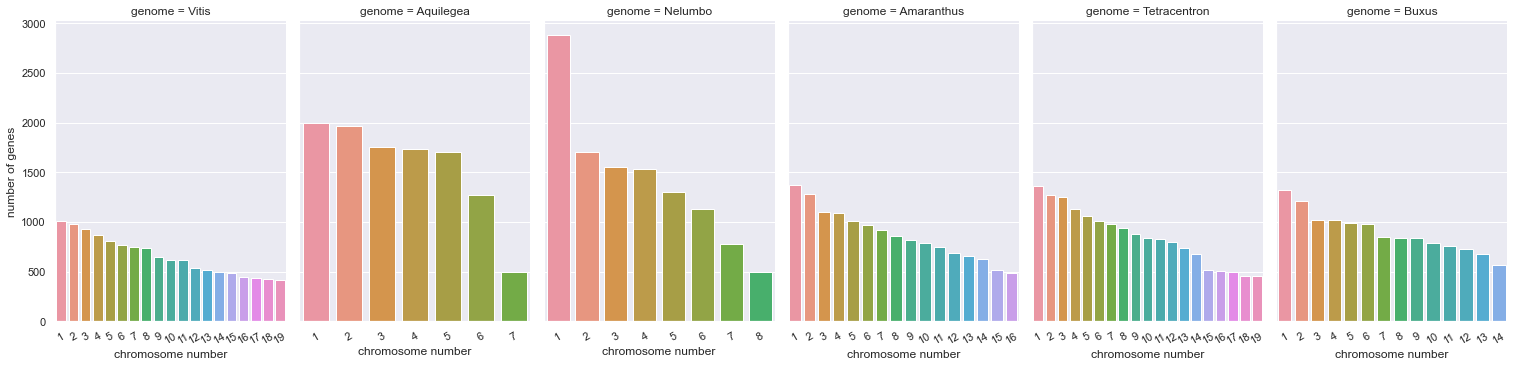

In [13]:
print("Visualizing the number of gene families in each chromosome of each genome")

data = {'genome': genomes, 'chromosome number': chromosomes, 'number of gene families': gene_lengths}

pddata = pd.DataFrame(data)

sns.set(style="darkgrid")

g = sns.catplot(x = 'chromosome number', y = 'number of gene families', col = 'genome', data = pddata, kind="bar", aspect = .7, sharex = False, dodge = False)
g.set_xticklabels(rotation = 30)

# Section 4: Extract gene proximity (or adjacencies) from each extant genome

Identify generalized gene adjacencies with a user specified window/gap size. The size parameter (*ws*) is defined in the configuration file. 
In order to succesfully prepare adjacency data for the Maximum Weight Matching algorithm, we require:
- Successful separation of input data

## Collecting Gene Adjacencies for Maximum Weight Matching

Adjacencies are extracted from gene orders in each extant genome. <br>
A large number of (generalized) adjacencies is collected for each ancestor defined in *median_structure*. 


Number of edges are the same since the number of genes and window size is consistent for each ancestor. However, the weights will be different.

In [14]:
# preparing data for maximum weight matching + maximum weight matching
window_size = parsed_config['ws']
min_adj_weight = parsed_config['min_mwm_weight']
num_gene_families = len(gene_family.gene_family)

input_tree_node = MWMInputTreeNode(genome, all_leaves)

mwmin_output_template = parsed_config['output_file']['mwm_input_template']

num_anc = 1
mwm_inputs = [None] * len(median_structure)

for i, structure in tqdm(enumerate(median_structure), total=len(mwm_inputs)):
    outfile_mwmin = directory + mwmin_output_template + str(num_anc) + ".txt"
    mwm_inputs[num_anc - 1] = input_tree_node.get_mwm_input(structure, num_gene_families, window_size, min_adj_weight, outfile_mwmin)
    num_anc += 1

100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


# Section 5: Maximum Weight Matching
In order to successfully complete the Maximum Weight Matching algorithm, we require:
- Successful preparation of Maximum Weight Matching Input Data

## Maximum Weight Matching


Produces the result of Maximum Weight Matching for each ancestor. <br>
This step is computationally expensive. <br>
Uses multiprocessing to speed up the process.

In [15]:
# The path of output file in general form
mwm_output_template = parsed_config['output_file']['mwm_output_template']

def mwm_matching(mwm_input, num_anc):
    outfile_mwmout = directory + mwm_output_template + str(num_anc) + ".txt"
    maxWeightMatching(mwm_input, outfile_mwmout)

In [16]:
# inputs for multiprocessing
numbers = [i for i in range(1, num_anc)]
inputs = zip(mwm_inputs, numbers)

start = time.time()

# multiprocessing to make workflow faster
with tqdm_joblib.tqdm_joblib(tqdm(desc = "Maximum Weight Matching", total = len(mwm_inputs))) as progress_bar:
    Parallel(n_jobs=(num_anc - 1))(delayed(mwm_matching)(mwm_inputs[i], numbers[i]) for i in range (0, len(mwm_inputs)))

end = time.time()

100%|██████████| 4/4 [17:37<00:00, 264.38s/it]


In [17]:
print("MWM solution was computed in %d minutes" % int((end - start)/60))

MWM solution was computed in 17 minutes


# Section 6: Constructing Ancestral Contigs
In order to succesfully construct ancestral contigs, we require:
- Successful Maximum Weight Matching on the prepared input data

## Creating Contigs

Produces the contigs for each ancestor.

In [18]:
# creating contigs from the maximum weight matching output
contig_template = parsed_config['output_file']['contig_template']

# string to use for next step
dcj_files = []

for i in tqdm(range(1, num_anc), total = len(mwm_inputs)):
    outfile_mwmout = directory + mwm_output_template + str(i) + ".txt"
    outfile_contig = directory + contig_template + str(i) + ".txt"
    dcj_files.append(outfile_contig)
    
    contig = Contig(outfile_mwmout, int(num_gene_families))
    contig.get_edge()
    list_telomeres = contig.find_telomeres()
    
    contig_list = contig.get_contigs(list_telomeres, outfile_contig, str(i))


100%|██████████| 4/4 [00:00<00:00,  8.81it/s]


# Section 7: Calculating DCJ Distance Between Ancestors
In order to succesfully calculate the DCJ Distance between ancestors, we require:
- Successful creation of ancestral contigs

## Calculating DCJ Distance


In [19]:
jar_path = parsed_config['input_file']['jar_path']

dcj_output = []

# Calculate DCJ Distance
print("Starting DCJ Calculations, May Take a While")

for i in tqdm(range(1, num_anc)):
    for j in range(i + 1, num_anc):
        dcj_output_path = directory + parsed_config['output_file']['dcj_output_path'] + str(i) + "_" + str(j) + ".txt"
        command = "java -jar " + jar_path + "/UniMoG-java11.jar " + str(dcj_files[i - 1]) + " " + str(dcj_files[j - 1]) + " -m=1 -p >" + dcj_output_path
        dcj_output.append(dcj_output_path)
        #print(command)
        print("Computing DCJ distance between ancestors", i, "and", j)
        os.system(command)
        
print("Calculation Done")


  0%|          | 0/4 [00:00<?, ?it/s]

Starting DCJ Calculations, May Take a While
Computing DCJ distance between ancestors 1 and 2
Computing DCJ distance between ancestors 1 and 3
Computing DCJ distance between ancestors 1 and 4



 25%|██▌       | 1/4 [00:37<01:52, 37.38s/it]

Computing DCJ distance between ancestors 2 and 3
Computing DCJ distance between ancestors 2 and 4



 50%|█████     | 2/4 [01:04<01:02, 31.38s/it]

Computing DCJ distance between ancestors 3 and 4



100%|██████████| 4/4 [01:15<00:00, 18.93s/it]

Calculation Done


In [20]:
dcj_summary = directory + parsed_config['output_file']['dcj_summary_path']
dcj_matrix = []

with open(dcj_summary, 'w') as dcj_summary_file:
    for i in range(len(median_structure)):
            dcj_summary_file.write("Median Structure for Ancestor " + str((i + 1)) + ": " + "%s" % median_structure[i] + "\n")
            
    for file in dcj_output:
        path = file
            
        with open(path, 'r') as dcj_file:
            dcj_info = dcj_file.readlines()
            
        dcj_summary_file.write(dcj_info[0])
        print(dcj_info[0])
        
        distance = int((dcj_info[0].split())[-1])
        dcj_matrix.append(distance)
        
print("Summay of pairwise DCJ distance -- Done")

In [ ]:
matrix_indices = [("Ancestor " + str(i)) for i in range (1, num_anc)]
dcj_matrix_summary = pd.DataFrame(squareform(dcj_matrix), index=matrix_indices, columns=matrix_indices)
dcj_matrix_summary.style.set_caption("DCJ Distance Summary Symmetric Matrix")
dcj_matrix_summary